<a href="https://colab.research.google.com/github/ihatestudysomuch/pytorch/blob/main/Pytorch_11%EC%9E%A5_MLP_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## MLP(Multi Layer Perceptron) MNIST
* 전 강의에서 배우긴 했지만 다시 복습!



1.   MNIST는 손으로 직접 쓴 흑백의 숫자(필기체 숫자)들로 이루어진 데이터
2.   딥러닝을 배울 때 꼭 거쳐가는 "Hello ,World"와 같은 존재
  - 28 * 28 크기의 숫자 이미지(X)와 0~9 까지의 정답(y)으로 이루어진 60,000개의 학습 데이터와 10,000개의 테스트 데이터로 구성되어 있음






## 딥러닝 MLP 구조



1.   입력층은 28 * 28 크기의 이미지를 1차원 벡터 즉, 784(28 * 28)개의 길이를 갖는 1차원 벡터로 변환해 은닉층으로 전달한다.

1.   은닉층은 일반적으로 1개 이상의 은닉층으로 이루어져 있으며, 내부에 많은 노드로 구성되어있고 은닉층의 개수, 노드 개수로 학습 데이터와 성능 등을 고려하여 최적의 값을 찾아야한다.
2.   ReLU는 활성함수로 입력값 if 입력값 > 0 else 0으로 출력하는 비선형 함수


2.   Droptout은 학습 데이터에 대한 과적합을 줄이기 위해 신경망을 주어진 확률값에 따라 부분적으로 제거하는 함수


1.   출력층은 MNIST가 총 0~9까지 10개의 정답(label)을 가지기 때문에 정답 개수와 같은 10개로 설정한다.
2.   Softmax는 다중 클래스로 분류 모델을 사용하며, 입력된 벡터의 각 요소를 0 ~ 1 사이의 확률값으로 변환해주는 함수이다.





In [1]:

import torch
from torch import nn
from torchvision import datasets # pytorch에서 제공하는 image dataset
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np


In [2]:
# data
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor()) # train data, transforms으로 0~255까지의 값을 0~1 사이의 값으로 변환 시켜줌 즉, 정규화
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor()) # test data, transforms로 정규화

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 130MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 19.3MB/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 54.8MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 1.82MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [4]:
# print(train_dataset)
# print(test_dataset)

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()


In [6]:
# test data는 그대로 두고 train data에서 train, validation을 0.85, 0.15 비율로 나누기
trian_dataset_size = int(len(train_dataset) * 0.85)
validation_dataset_size = int(len(train_dataset) * 0.15)

# train_dataset을 train, validation으로 random하게 나누기
train_dataset, validation_dataset = random_split(train_dataset, [trian_dataset_size, validation_dataset_size])

print(len(train_dataset), len(validation_dataset), len(test_dataset))

51000 9000 10000


In [7]:
# 모델
class MyDeppLearningModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.flatten = nn.Flatten() # 입력층
    self.fc1 = nn.Linear(784, 256) # 은닉층
    self.relu = nn.ReLU() # 비선형함수 ReLU
    self.dropout = nn.Dropout(0.3)
    self.fc2 = nn.Linear(256,10) # 출력층

  # 피드 포워드
  def forward(self, x):
    x = self.flatten(x) # 입력층
    x = self.fc1(x) # 은닉층
    x = self.relu(x) # 비선형함수 ReLU
    x = self.dropout(x)
    output = self.fc2(x) # 출력층
    return output


In [8]:
BATCH_SIZE = 32

# batch data
train_dataloader = DataLoader(dataset = train_dataset, batch_size = BATCH_SIZE, shuffle = True)
validation_dataloader = DataLoader(dataset = validation_dataset, batch_size = BATCH_SIZE, shuffle = True)
test_dataloader = DataLoader(dataset = test_dataset, batch_size = BATCH_SIZE, shuffle = True)

In [10]:
# 손실함수, 옵티마이저
model = MyDeppLearningModel()

loss_function = nn.CrossEntropyLoss() # 손실함수 Cross Entropy, 0, 1로 binary 출력이 아니기 때문에 BCE가 아닌 Cross Entropy 사용, 그리고 Softmax가 들어있음
optimizer = torch.optim.SGD(model.parameters(), lr = 1e-2) # 옵티마이저 SGD(단층 경사 하강법)


In [12]:
# train 학습 정의
def model_train(dataloader, model, loss_function, optimizer):
  model.train() # 딥러닝 모델 학습모드로 전환

  train_loss_sum = train_correct = train_total = 0
  total_train_batch = len(dataloader)

  for images, labels in dataloader:
    x_train = images.view(-1, 28*28) # 2차원 벡터를 1차원 벡터로 변경, dataloader(여기서는 train_dataloader)에는 MNIST images(x_train)과 0~9의 정답(labels)로 이루어져있다.
    y_train = labels # 0~9 정답값

    output = model(x_train) # 예측값
    loss = loss_function(output, y_train) # 오차

    # 역전파(W, q 업데이트)
    optimizer.zero_grad() # 기울기 초기화
    loss.backward() # 역전파
    optimizer.step() # 가중치 갱신

    train_loss_sum += loss.item()

    train_total += y_train.size(0)
    train_correct += ((torch.argmax(output, 1) ==y_train)).sum().item()

  avg_loss = train_loss_sum / total_train_batch
  avg_acc =  100 * train_correct / total_train_batch


  return (avg_loss, avg_acc)

In [13]:
# validation 평가 정의
def model_evaluate(dataloader, model, loss_function, optimizer):

    model.eval() # 딥러닝 모델을 학습모드에서 추론(검증)모드로 전환

    with torch.no_grad(): #미분하지 않겠다는 것 즉, 모델 파라미터인 W, b를 업데이트 하지 않겠다고 선언하는 것이 일반적

        val_loss_sum = 0
        val_correct=0
        val_total = 0

        total_val_batch = len(dataloader)

        for images, labels in dataloader: # images에는 이미지, labels에는 0-9 숫자

            # reshape input image into [batch_size by 784]
            # label is not one-hot encoded
            x_val = images.view(-1, 28 * 28) #처음 크기는 (batch_size, 1, 28, 28) / 이걸 (batch_size, 784)로 변환
            y_val = labels

            # 역전파 코드는 존재하지 않음(W, b를 업데이트 하지 않으니까~)

            outputs = model(x_val)
            loss = loss_function(outputs, y_val)

            val_loss_sum += loss.item()

            val_total += y_val.size(0)  # label 열 사이즈 같음
            val_correct += ((torch.argmax(outputs, 1)==y_val)).sum().item() # 예측한 값과 일치한 값의 합

        val_avg_loss = val_loss_sum / total_val_batch
        val_avg_accuracy = 100*val_correct / val_total

    return (val_avg_loss, val_avg_accuracy)

In [14]:
# 학습, 평가 시작
from datetime import datetime

train_loss_list = []
train_accuracy_list = []

val_loss_list = []
val_accuracy_list = []

start_time = datetime.now()

EPOCHS = 20

for epoch in range(EPOCHS):

    #==============  model train  ================
    train_avg_loss, train_avg_accuracy = model_train(train_dataloader, model, loss_function, optimizer)  # training

    train_loss_list.append(train_avg_loss)
    train_accuracy_list.append(train_avg_accuracy)
    #=============================================

    #============  model evaluation  ==============
    val_avg_loss, val_avg_accuracy = model_evaluate(validation_dataloader, model, loss_function, optimizer)  # evaluation

    val_loss_list.append(val_avg_loss)
    val_accuracy_list.append(val_avg_accuracy)
    #============  model evaluation  ==============

    print('epoch:', '%02d' % (epoch + 1),
          'train loss =', '{:.4f}'.format(train_avg_loss), 'train accuracy =', '{:.4f}'.format(train_avg_accuracy),
          'validation loss =', '{:.4f}'.format(val_avg_loss), 'validation accuracy =', '{:.4f}'.format(val_avg_accuracy))

end_time = datetime.now()

print('elapsed time => ', end_time-start_time)


epoch: 01 train loss = 0.9803 train accuracy = 2445.9849 validation loss = 0.4512 validation accuracy = 88.8778
epoch: 02 train loss = 0.4408 train accuracy = 2807.0891 validation loss = 0.3444 validation accuracy = 90.5000
epoch: 03 train loss = 0.3689 train accuracy = 2863.7390 validation loss = 0.3019 validation accuracy = 91.7000
epoch: 04 train loss = 0.3274 train accuracy = 2902.1330 validation loss = 0.2735 validation accuracy = 92.3444
epoch: 05 train loss = 0.2983 train accuracy = 2929.3601 validation loss = 0.2518 validation accuracy = 93.0889
epoch: 06 train loss = 0.2753 train accuracy = 2948.8080 validation loss = 0.2333 validation accuracy = 93.5556
epoch: 07 train loss = 0.2546 train accuracy = 2967.1267 validation loss = 0.2178 validation accuracy = 93.9889
epoch: 08 train loss = 0.2398 train accuracy = 2981.6813 validation loss = 0.2052 validation accuracy = 94.4333
epoch: 09 train loss = 0.2261 train accuracy = 2997.6788 validation loss = 0.1942 validation accuracy = 

In [16]:
def model_test(dataloader, model):

    model.eval()

    with torch.no_grad(): #test set으로 데이터를 다룰 때에는 gradient를 주면 안된다.

        test_loss_sum = 0
        test_correct=0
        test_total = 0

        total_test_batch = len(dataloader)

        for images, labels in dataloader: # images에는 이미지, labels에는 0-9 숫자

            # reshape input image into [batch_size by 784]
            # label is not one-hot encoded
            x_test = images.view(-1, 28 * 28) #처음 크기는 (batch_size, 1, 28, 28) / 이걸 (batch_size, 784)로 변환
            y_test = labels

            outputs = model(x_test)
            loss = loss_function(outputs, y_test)

            test_loss_sum += loss.item()

            test_total += y_test.size(0)  # label 열 사이즈 같음
            test_correct += ((torch.argmax(outputs, 1)==y_test)).sum().item() # 예측한 값과 일치한 값의 합

        test_avg_loss = test_loss_sum / total_test_batch
        test_avg_accuracy = 100*test_correct / test_total

        print('accuracy:', test_avg_accuracy)
        print('loss:', test_avg_loss)

In [17]:
# test dataset 으로 정확도 및 오차 테스트

model_test(test_dataloader, model)

accuracy: 96.38
loss: 0.12260108923884674


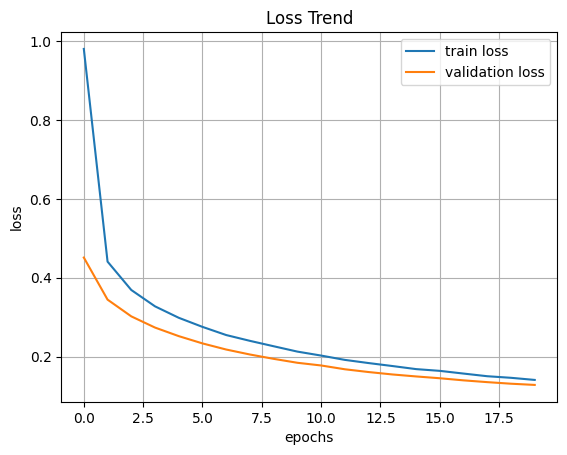

In [18]:
import matplotlib.pyplot as plt

plt.title('Loss Trend')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()

plt.plot(train_loss_list, label='train loss')
plt.plot(val_loss_list, label='validation loss')

plt.legend()

plt.show()


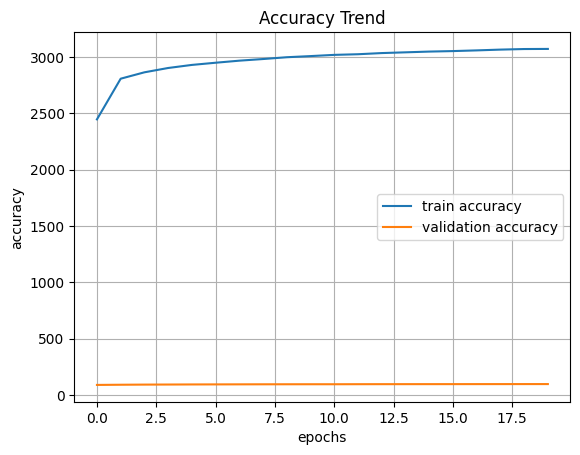

In [19]:

import matplotlib.pyplot as plt

plt.title('Accuracy Trend')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.grid()

plt.plot(train_accuracy_list, label='train accuracy')
plt.plot(val_accuracy_list, label='validation accuracy')

plt.legend()

plt.show()

# 결과가 이상한 건 train의 acc이 이상하게 계산한 거 같음! 아무튼 acc는 반복할 때마다 오름